In [71]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from pathlib import Path
pd.set_option('display.max_columns', None)

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [72]:
DATA_PATH = Path('')

# Load files
train = pd.read_csv(DATA_PATH / 'Train.csv')
test = pd.read_csv(DATA_PATH / 'Test.csv')
sample_submission = pd.read_csv(DATA_PATH / 'SampleSubmission.csv')

In [73]:
# Preview the first five rows of the train set
train.head()

,id,site_id,site_latitude,site_longitude,city,country,date,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,uvaerosollayerheight_aerosol_height,uvaerosollayerheight_aerosol_pressure,uvaerosollayerheight_aerosol_optical_depth,uvaerosollayerheight_sensor_zenith_angle,uvaerosollayerheight_sensor_azimuth_angle,uvaerosollayerheight_solar_azimuth_angle,uvaerosollayerheight_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5
0,id_vjcx08sz91,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-10-25,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.052301,828817.9375,-100.805145,21.720518,-123.523796,33.745914,0.122055,2.301404,0.285803,230.693756,0.906039,-100.805145,21.720518,-123.523796,33.745914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.015000
1,id_bkg215syli,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-02,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,0.045475,3771.027210,3399.756845,828569.623806,69.245351,59.159695,-143.370575,26.566997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000214,1.462390,0.000240,0.359150,26.525513,-143.480164,59.220097,70.875954,-0.315206,828578.6250,70.875954,59.220097,-143.480164,26.525513,0.116975,3.049902,0.362203,228.260193,0.364713,70.875954,59.220097,-143.480164,26.525513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.267200
2,id_oui2pot3qd,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-03,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.097816,828878.6875,-96.411942,61.045010,-121.307121,41.898113,0.117559,3.248703,0.384168,224.102463,0.754163,-96.411942,61.045010,-121.307121,41.898113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7

In [74]:
# Preview the first five rows of the test set
test.head()

,id,site_id,site_latitude,site_longitude,city,country,date,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,uvaerosollayerheight_aerosol_height,uvaerosollayerheight_aerosol_pressure,uvaerosollayerheight_aerosol_optical_depth,uvaerosollayerheight_sensor_zenith_angle,uvaerosollayerheight_sensor_azimuth_angle,uvaerosollayerheight_solar_azimuth_angle,uvaerosollayerheight_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle
0,id_ihxgrbq8bw,64f9d17ab9e98d001ac9e882,5.61252,-0.22955,Accra,Ghana,2023-09-06,13,-0.000072,0.762543,-0.000055,0.079645,-100.330299,26.926420,-86.879776,25.512329,-0.000028,9.0,0.043537,2825.323242,1.000000,829406.9375,-97.787621,26.897718,-86.884308,25.509418,0.000055,0.000016,0.000040,0.000109,9582.745678,-0.258421,0.019749,829420.312500,-100.330299,26.926420,-86.879776,25.512329,0.000243,1.112240,0.000213,0.079645,25.512329,-86.879776,26.926420,-100.330299,-0.258422,829420.312500,-100.330299,26.926420,-86.879776,25.512329,0.126056,2.243713,0.286278,230.244171,0.079324,-100.330299,26.926420,-86.879776,25.512329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.043065,74217.403083,2710.544562,83569.504246,1710.544483,3.063105,0.263193,-100.317077,27.059646,-86.885670,25.530511
1,id_dg6s4fhiwe,64f9d17ab9e98d001ac9e882,5.61252,-0.22955,Accra,Ghana,2023-09-07,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,0.036341,2604.788330,1584.809692,829328.6250,70.753090,11.428769,-87.764297,20.935318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.408162,829340.750000,76.400116,11.171532,-87.726566,20.951560,0.126282,2.136400,0.273757,230.184377,0.613266,76.400116,11.171532,-87.726566,20.951560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,id_f7hwwtmuzp,64f9d17ab9e98d001ac9e882,5.61252,-0.22955,Accra,Ghana,2023-09-08,13,-0.000051,1.004265,-0.000051,0.163160,73.117264,43.112466,-89.089083,16.417355,-0.000023,9.0,0.037453,3046.3140

In [75]:
# Preview the first five rows of the sample submission file
sample_submission.head()

,id,pm2_5
0,id_ihxgrbq8bw,0
1,id_dg6s4fhiwe,0
2,id_f7hwwtmuzp,0
3,id_ioese5awdg,0
4,id_hdw320zpls,0


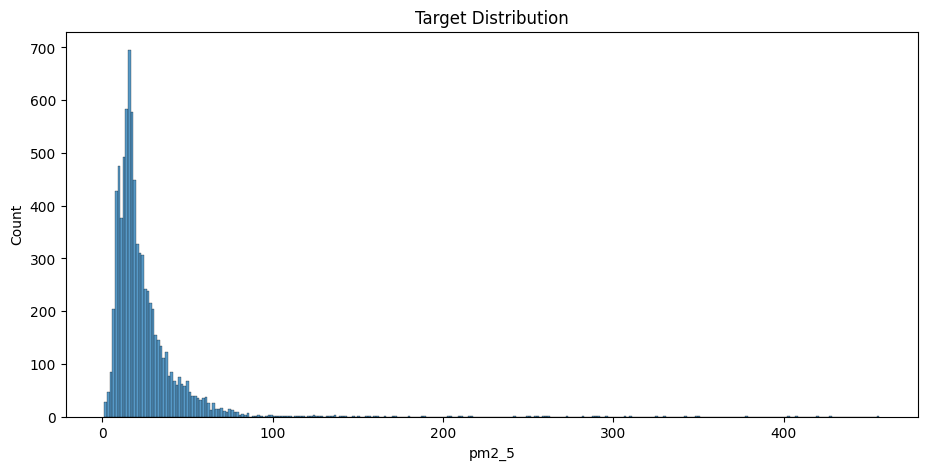

In [76]:
# target distribution
plt.figure(figsize = (11, 5))
sns.histplot(train.pm2_5)
plt.title('Target Distribution')
plt.show()

In [77]:
import pandas as pd
from scipy.stats.mstats import winsorize

# Basically what i did is limit remove the 3% of data that represnts the extreme data values (outliers) for the pm2_5 attribute
winsor_percentile = 3

# Winsorize the PM2.5 column to handle outliers
train['pm2_5'] = winsorize(train['pm2_5'], limits=(winsor_percentile/100., winsor_percentile/100.))


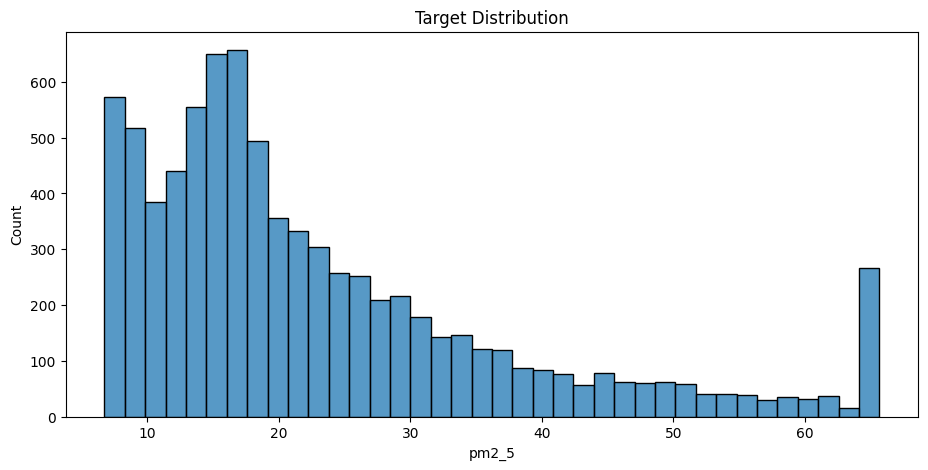

In [78]:
# target distribution
plt.figure(figsize = (11, 5))
sns.histplot(train.pm2_5)
plt.title('Target Distribution')
plt.show()

- From the target distribution histogram we can see that the distribution is skewed to the right.
- Some processing of the target is recommended

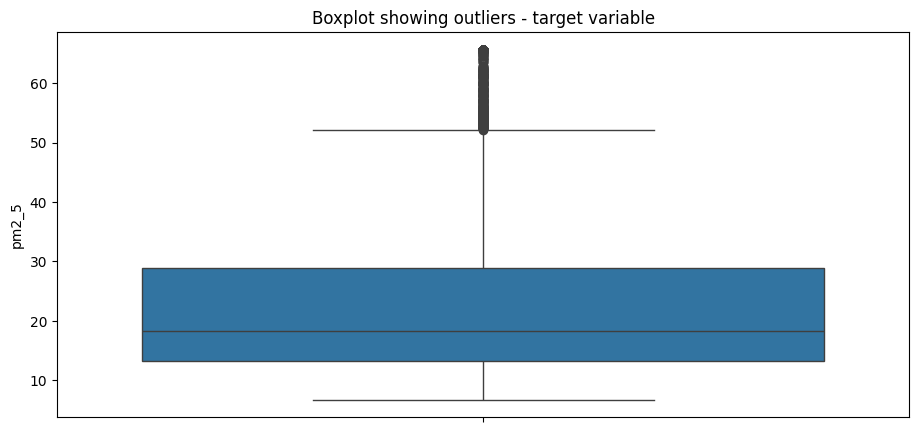

In [79]:
# Check for outliers in the target variable
plt.figure(figsize = (11, 5))
sns.boxplot(train.pm2_5)
plt.title('Boxplot showing outliers - target variable')
plt.show()

- The target variable has some outliers that are beyond the 180 mark.
- Outliers can be handled via
  - Dropping them
  - Cap outliers - set a maximum
  - Assign a new value to the outliers
  - Transform the target variable


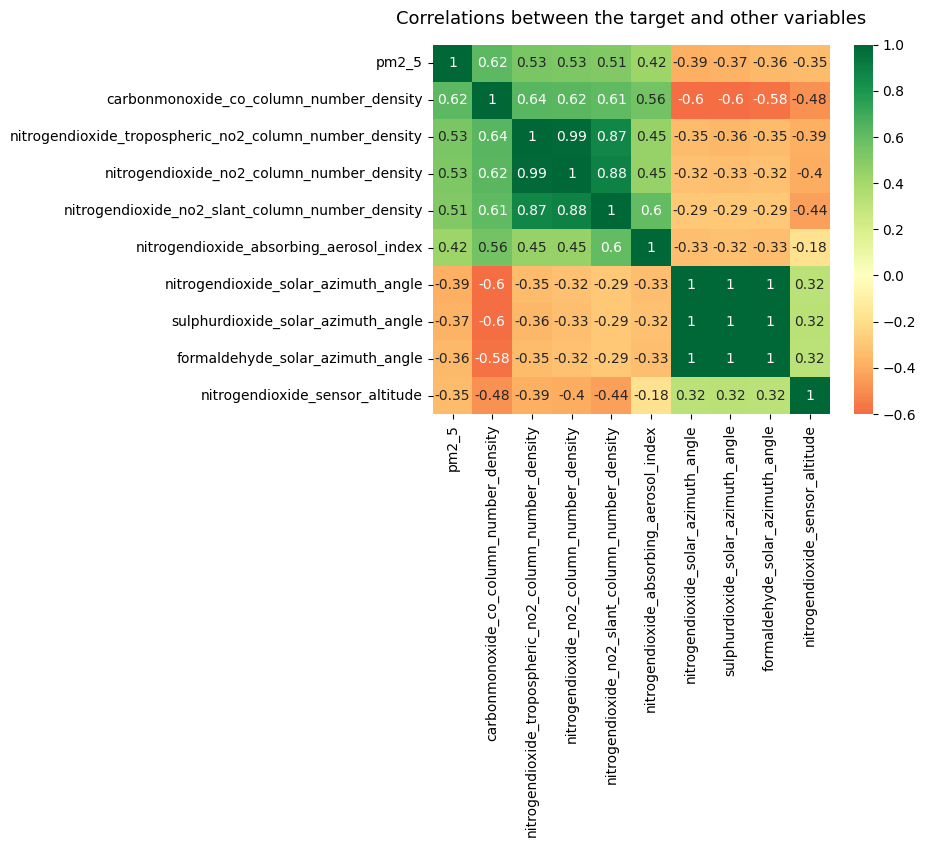

In [80]:
# Select only numerical features
train_num_df = train.select_dtypes(include=['number'])
test_num_df =test.select_dtypes(include=['number'])

top10_corrs = abs(train_num_df.corr()['pm2_5']).sort_values(ascending = False).head(10)
corr = train_num_df[list(top10_corrs.index)].corr()
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlations between the target and other variables', pad = 15, fontdict={'size': 13})
plt.show()

In [81]:
# Select X and y features for modelling
X = train_num_df.drop('pm2_5', axis = 1)
y = train.pm2_5

test_df = test_num_df[X.columns]
test_df.head()

,site_latitude,site_longitude,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,uvaerosollayerheight_aerosol_height,uvaerosollayerheight_aerosol_pressure,uvaerosollayerheight_aerosol_optical_depth,uvaerosollayerheight_sensor_zenith_angle,uvaerosollayerheight_sensor_azimuth_angle,uvaerosollayerheight_solar_azimuth_angle,uvaerosollayerheight_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle
0,5.61252,-0.22955,13,-0.000072,0.762543,-0.000055,0.079645,-100.330299,26.926420,-86.879776,25.512329,-0.000028,9.0,0.043537,2825.323242,1.000000,829406.9375,-97.787621,26.897718,-86.884308,25.509418,0.000055,0.000016,0.000040,0.000109,9582.745678,-0.258421,0.019749,829420.312500,-100.330299,26.926420,-86.879776,25.512329,0.000243,1.112240,0.000213,0.079645,25.512329,-86.879776,26.926420,-100.330299,-0.258422,829420.312500,-100.330299,26.926420,-86.879776,25.512329,0.126056,2.243713,0.286278,230.244171,0.079324,-100.330299,26.926420,-86.879776,25.512329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.043065,74217.403083,2710.544562,83569.504246,1710.544483,3.063105,0.263193,-100.317077,27.059646,-86.885670,25.530511
1,5.61252,-0.22955,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,0.036341,2604.788330,1584.809692,829328.6250,70.753090,11.428769,-87.764297,20.935318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.408162,829340.750000,76.400116,11.171532,-87.726566,20.951560,0.126282,2.136400,0.273757,230.184377,0.613266,76.400116,11.171532,-87.726566,20.951560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.61252,-0.22955,13,-0.000051,1.004265,-0.000051,0.163160,73.117264,43.112466,-89.089083,16.417355,-0.000023,9.0,0.037453,3046.314001,90.699029,829194.5625,71.272375,43.172868,-88.964294,16.440554,0.000062,0.000027,0.000036,0.000134,9582.743944,-0.115200,0.163328,829204.480816,73.117264,43.112466,-89.089083,16.417355,0.000145,1.345840,0.000127,

In [82]:
# Train model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

model = LGBMRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
    
rmse = mean_squared_error(y_test, y_pred, squared=False)
    
print(rmse)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16874
[LightGBM] [Info] Number of data points in the train set: 5649, number of used features: 74
[LightGBM] [Info] Start training from score 23.068756
7.489399766845475


In [83]:
# Make predictions on the test set
preds = model.predict(test_df)
# Create submission file
sub = pd.DataFrame({'id': test['id'], 'pm2_5': preds})
# Preview sub file
sub.head()

,id,pm2_5
0,id_ihxgrbq8bw,21.381308
1,id_dg6s4fhiwe,24.176709
2,id_f7hwwtmuzp,16.474860
3,id_ioese5awdg,22.458442
4,id_hdw320zpls,18.430214


In [84]:
# Create a csv file
sub.to_csv('submission.csv', index = False)